# Minst Clothing Classification using Convolutional Neural Networks


## Some definitions before getting into the coding part:
- __CNNs:__ Convolutional neural network. That is, a network which has at least one convolutional layer. A typical CNN also includes other types of layers, such as pooling layers and dense layers.

- __Convolution:__ The process of applying a kernel (filter) to an image
Kernel / filter: A matrix which is smaller than the input, used to transform the input into chunks

- __Padding:__ Adding pixels of some value, usually 0, around the input image

- __Pooling:__ The process of reducing the size of an image through downsampling.There are several types of pooling layers. For example, average pooling converts many values into a single value by taking the average. However, maxpooling is the most common.

- __Maxpooling:__ A pooling process in which many values are converted into a single value by taking the maximum value from among them. (Reducing the size of an input image by summarizing the regions).

- __Stride:__ the number of pixels to slide the kernel (filter) across the image.

- __Downsampling:__ The act of reducing the size of an image

### Let's start by importing libararies required for this project

In [1]:
import tensorflow as tf

# tensorflow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Herlper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Let's import Fashion MNIST dataset

In [2]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised= True, with_info= True)
train_ds, test_ds = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
class_names = metadata.features['label'].names
print('Class names: {}'.format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Let's get on with exploring the dataset by checking the number of images in training and test set.

In [4]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('Number of images in train set: {}'.format(num_train_examples))
print('Number of images in test set: {}'.format(num_test_examples))

Number of images in train set: 60000
Number of images in test set: 10000


## Preprocessing dataset by normalizing the images in the range[0,1].

In [5]:
# function for normalizing to make it easier for the optimization algorithm to find best weights during training.
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

In [6]:
train_ds = train_ds.map(normalize)
test_ds = test_ds.map(normalize)

In [8]:
# Caching will keep the dataset in memory, making training faster.
train_ds = train_ds.cache()
test_ds = test_ds.cache()

## Let's Explore the processed dataset

Let's visualize a Single Image __:__

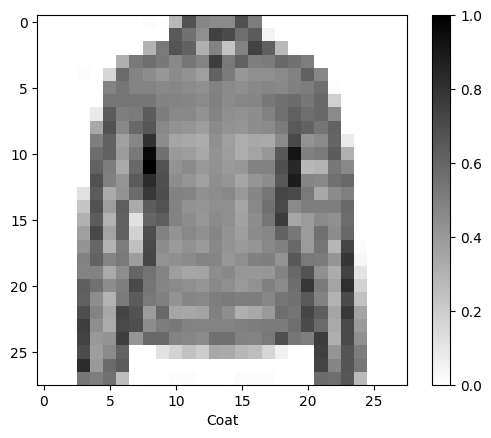

In [9]:
for image, label in test_ds.take(1):
  break
image = image.numpy().reshape((28,28))
plt.figure()
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.xlabel(class_names[label])
plt.show()

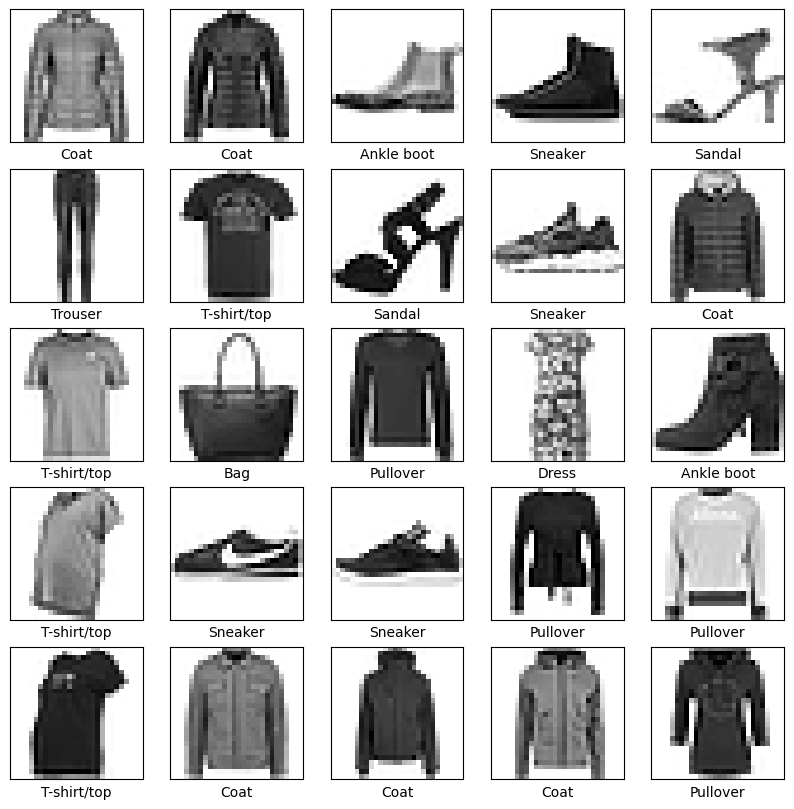

In [10]:
plt.figure(figsize = (10,10))
for i, (image, label) in enumerate(test_ds.take(25)):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap = plt.cm.binary)
  plt.xlabel(class_names[label])
plt.show()

### Now let's build the model using Convolutional neural network (CNN) layers with maxpooling layers:

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape = (28,28,1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides = 2),
    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 128, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 10, activation = tf.nn.softmax)
])

This network layers are:
- __"Convolutions"__ `tf.keras.layers.Conv2D` and `MaxPooling2D`-- Network start with two pairs of Conv/MaxPool. The first layer is a Conv2D filters (3,3) being applied to the input image, retaining the original image size by using padding, and creating 32 output (Convoluted) images (so this layer creates 32 convoluted images of the same size as input). After that, the 32 outputs are reduced in size using a `MaxPooling2D`(2,2) with a stride of 2. The next Conv2D also has (3,3) kernal, takes the 32 images as input and creates 64 outputs which are again reduced in size by a `MaxPooling2D` layer.

- __output__ `tf.keras.layers.Dense` -- A 128-neuron, followed by 10-node softmax layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layers before it, and outputs a value in the range `[0,1]`, representing the probability that the image belongs to that class. The sum of all 10 nodes is 1.

## Compile the model

Before we train the model, we need to add a few more things which is done in the model's compile step:
- __Loss Function__ : An algorithm for measuring how far the model's outputs are from the desired output. The goal of this is measuring loss.

- __optimizer__ : An algorithm for adjusting the inner parameters of the model in order to minimize loss.

- __metrics__ : Used to monitor the training and testing steps. The following example uses _accuracy_, the fraction of the images that are correctly classified.

In [12]:
model.compile(optimizer = 'adam',
            loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

## Train the model

First, we define the iteration behaviour for the train dataset:

1. Repeat forever by specifying `dataset.repeat()`.
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

In [13]:
BATCH_SIZE = 32
train_ds = train_ds.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_ds = test_ds.cache().batch(BATCH_SIZE)

Training is performed using `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learn to associate images and labels.
3. The `epoch=5` parameter limits training to 5 full iterations of the training dataset, so a total of 60000*5 = 300000 examples.

In [14]:
model.fit(train_ds, epochs = 5, steps_per_epoch= math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 24s 4ms/step - loss: 0.3935 - accuracy: 0.8572
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2574 - accuracy: 0.9063
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2087 - accuracy: 0.9240
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1790 - accuracy: 0.9332
Epoch 5/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1536 - accuracy: 0.9433


This time as we trained our model using CNN our model has achieved an accuracy of around 94% which is more than our previous accuracy of 89%. So, CNNs are much better than our previous simple model.

# Evaluate accuracy

Let's see how our model performs on test data using all examples we have in test dataset.

In [35]:
test_loss, test_accuracy = model.evaluate(test_ds, steps = math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.2368 - accuracy: 0.9188
Accuracy on test dataset: 0.9187999963760376


Also, in test set we have achieved a significant increase in the accuracy of 91%.

# Make predictions and explore

As our model is trained let's use it to make predictions about some images.

In [36]:
for test_images, test_labels in test_ds.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 16ms/step


In [17]:
predictions.shape

(32, 10)

In [18]:
predictions[0]

array([1.1821353e-06, 4.4810341e-07, 6.3251620e-03, 3.5347924e-08,
       9.8574728e-01, 7.2440045e-08, 7.9213176e-03, 1.3680626e-08,
       7.3499038e-08, 4.2952151e-06], dtype=float32)

Above prediciton is an array of 10 numbers. These describe the "confidence" of the model that image corresponds to each of the 10 different articles of clothing. Here we can see which label has the highest confidence value:

In [19]:
np.argmax(predictions[0])

4

So the model is most confident that this image is coat, or `class_names[4]`. And we can check the test label to see this is correct:

In [20]:
test_labels[0]

4

In [21]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap = plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel('{} {:2.0f}% ({})'.format(class_names[predicted_label],
                                       100*np.max(predictions_array),
                                       class_names[true_label]),
                                        color = color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color = '#777777')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

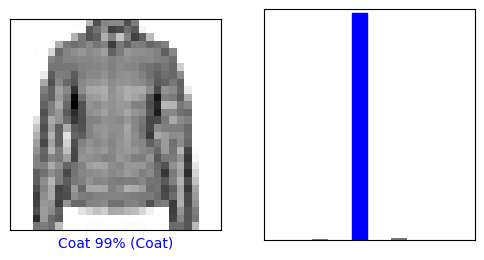

In [22]:
i = 0
plt.figure(figsize = (6, 3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

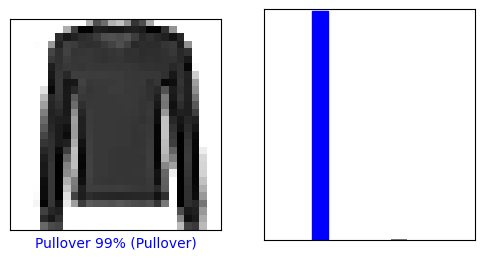

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i,predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. And, it can be wrong even when very confident.

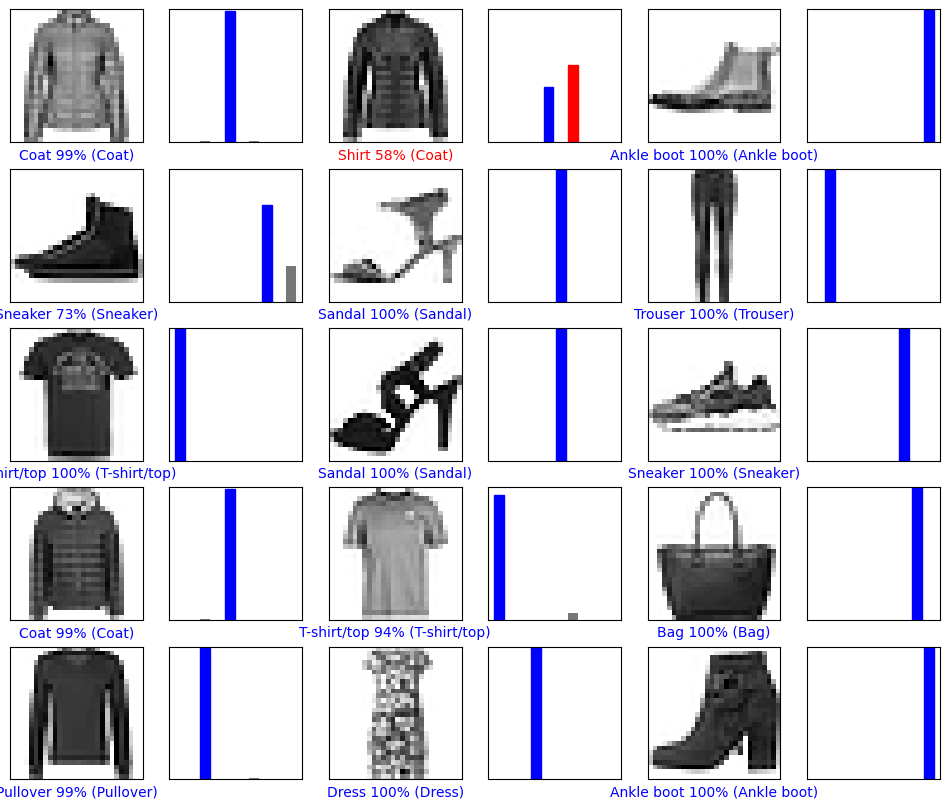

In [24]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize = (2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i,predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i,predictions, test_labels)

Lets predict a single image.

In [25]:
img = test_images[0]
print(img.shape)

(28, 28, 1)


In [26]:
# Add the image to a batch where it's the only member.
img = np.array([img])
print(img.shape)

(1, 28, 28, 1)


Now predict the image

In [27]:
predictions_single = model.predict(img)
print(predictions_single)

1/1 [==============================] - 0s 256ms/step
[[1.1821353e-06 4.4810295e-07 6.3251620e-03 3.5347988e-08 9.8574728e-01
  7.2440045e-08 7.9213139e-03 1.3680626e-08 7.3499038e-08 4.2952106e-06]]


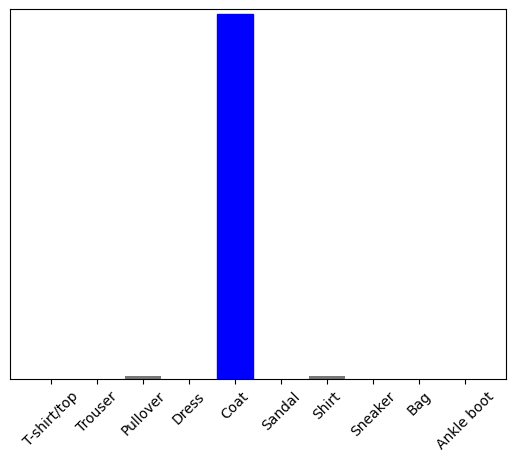

In [28]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation = 45)

`model.predict` returns a lists of lists, one for each image in the batch data. Grab the predictions for our (only) image in batch:

In [29]:
np.argmax(predictions_single[0])

4

And as before, the model predicts a label of 4 (coat).